## XGBoost

In [19]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


import warnings
warnings.filterwarnings('ignore')

In [20]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')
train_df.shape, test_df.shape

((2258, 168), (553, 138))

In [21]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Bangladesh', 'Ethnicity_North American / Central American', 'Country_New Zealand', 'Country_Georgia', 'Country_Andorra', 'Country_Latvia', 'Country_Lebanon', 'Country_Angola', 'Country_Cyprus', 'Country_Kosovo', 'Country_Philippines', 'Country_El Salvador', 'Country_Tanzania', 'Country_United Arab Emirates', 'Country_Kenya', 'Country_Malta', 'Country_Jordan', 'Country_Paraguay', 'Country_Costa Rica', 'Country_Slovakia', 'Country_Zimbabwe', 'Country_Mongolia', 'Country_Uzbekistan', 'Country_Venezuela', 'Country_North Macedonia', 'Country_Serbia', 'Country_Nomadic', 'Country_Peru', 'Country_Viet Nam', 'Country_Armenia', 'Country_Estonia', 'Country_Azerbaijan', 'Country_Botswana', 'Country_Yemen', 'Country_Croatia', 'Country_Sri Lanka', 'Country_Saudi Arabia', 'Country_Bosnia-Herz.'}
Columns in the test set that aren't in the train set: {"Country_CÃ´te d'Ivoire", 'Country_Republic of Korea', 'Country_Trinidad and Tobago', 'Co

## Baseline features:

In [22]:
'''# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

baseline_train_df.head()'''

'# Assuming you have a DataFrame called \'df\'\nbaseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]\n\n# Add Job_title columns to the baseline_cols list\nJob_title = [\'Developer, game or graphics\', \'Blockchain\', \'Developer, QA or test\', \'Developer, back-end\', \'Student\', \n             \'Project manager\', \'Data or business analyst\', \'Cloud infrastructure engineer\', \'Engineer, data\', \n             \'Educator\', \'Developer, desktop or enterprise applications\', \'Developer, front-end\', \'Designer\', \n             \'Security professional\', \'Developer, embedded applications or devices\', \'Product manager\', \'Developer, mobile\', \n             \'Developer, full-stack\', \'Scientist\', \'Database administrator\', \'Academic researcher\', \'Senior Executive (C-Suite, VP, etc.)\', \n             \'Marketing or sales professional\', \'System administrator\', \'Data scientist or machine learning specialist\', \n

In [23]:
'''X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = baseline_train_df['Annual_salary']
y_test = baseline_test_df['Annual_salary']

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)'''

"X_train = baseline_train_df.drop('Annual_salary', axis=1)\nX_test = baseline_test_df.drop('Annual_salary', axis=1)\ny_train = baseline_train_df['Annual_salary']\ny_test = baseline_test_df['Annual_salary']\n\nprint(X_train.shape)\nprint(y_train.shape)\nprint()\nprint(X_test.shape)\nprint(y_test.shape)"

### Sqrt transformation

In [24]:
y_train = np.sqrt(train_df['Annual_salary'])
y_test = np.sqrt(test_df['Annual_salary'])

----

In [25]:
X_train = train_df.drop('Annual_salary', axis=1)
X_test = test_df.drop('Annual_salary', axis=1)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_pipeline = Pipeline(steps=[
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

### Hyperparameter tunning

In [27]:
param_dist = {
    "regressor__n_estimators": randint(50, 500),
    "regressor__learning_rate": uniform(0.01, 0.3),
    "regressor__max_depth": randint(1, 20),
    "regressor__min_child_weight": randint(1, 10),
    "regressor__gamma": uniform(0, 1),
    "regressor__subsample": uniform(0.5, 0.5),
    "regressor__colsample_bytree": uniform(0.5, 0.5),
}


# RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_pipeline, param_distributions=param_dist, n_iter=50, 
    cv=KFold(n_splits=4, shuffle=True, random_state=42), 
    scoring="neg_mean_squared_error", n_jobs=-1, random_state=42, verbose=2
)

random_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('regressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           grow_po...
                                        'regressor__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C44E906BB0>,
                                        'regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C4470CA8B0>,
                                        'regressor__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C44EA3AA90>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [28]:
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

mse_score = -random_search.best_score_
rmse_score = np.sqrt(mse_score)

print(f"Best cross-validation RMSE score: {rmse_score}")

Best parameters found: {'regressor__colsample_bytree': 0.9460232775885566, 'regressor__gamma': 0.6311386259972629, 'regressor__learning_rate': 0.24844339106249452, 'regressor__max_depth': 1, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 366, 'regressor__subsample': 0.7495966899423762}
Best cross-validation RMSE score: 49.63680188419306


In [29]:
'''best_params = {'regressor__colsample_bytree': 0.8776807051588262, 'regressor__gamma': 0.4251558744912447, 
               'regressor__learning_rate': 0.07238249886045664, 'regressor__max_depth': 4, 'regressor__min_child_weight': 6, 
               'regressor__n_estimators': 240, 'regressor__subsample': 0.9211423872974993}'''

"best_params = {'regressor__colsample_bytree': 0.8776807051588262, 'regressor__gamma': 0.4251558744912447, \n               'regressor__learning_rate': 0.07238249886045664, 'regressor__max_depth': 4, 'regressor__min_child_weight': 6, \n               'regressor__n_estimators': 240, 'regressor__subsample': 0.9211423872974993}"

In [30]:
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def cv_metrics(cv_results):
    mse_mean = -cv_results['mean_test_score'].mean()
    rmse = np.sqrt(mse_mean)
    y_train_pred = np.square(random_search.best_estimator_.predict(X_train_scaled)) # Invertir la transformación sqrt
    r2 = r2_score(np.square(y_train), y_train_pred) # Invertir la transformación sqrt
    adj_r2 = adjusted_r2(r2, X_train_scaled.shape[0], X_train_scaled.shape[1])
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2}

cv_metrics(random_search.cv_results_)

{'R^2': 0.6919188113952061,
 'RMSE': 55.24774899663108,
 'Adjusted R^2': 0.6732428370859869}

In [31]:
xgb_results_dic = {}

xgb_results_dic['XGBoost'] = cv_metrics(random_search.cv_results_)

xgb_results = pd.DataFrame.from_dict(xgb_results_dic, orient='index')
print(xgb_results)

              R^2       RMSE  Adjusted R^2
XGBoost  0.691919  55.247749      0.673243


In [32]:
best_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
best_xgb.fit(X_train_scaled, y_train)

[19:25:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "regressor__colsample_bytree", "regressor__gamma", "regressor__learning_rate", "regressor__max_depth", "regressor__min_child_weight", "regressor__n_estimators", "regressor__subsample" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [33]:
y_pred = np.square(best_xgb.predict(X_test_scaled)) # Invertir la transformación sqrt para las predicciones
r2_test = r2_score(np.square(y_test), y_pred) # Invertir la transformación sqrt para y_test
rmse_test = mean_squared_error(np.square(y_test), y_pred, squared=False) # Invertir la transformación sqrt para y_test
adj_r2_test = adjusted_r2(r2_test, X_test_scaled.shape[0], X_test_scaled.shape[1])

print(f"\nTest set metrics:\nR^2: {r2_test}\nRMSE: {rmse_test}\nAdjusted R^2: {adj_r2_test}")


Test set metrics:
R^2: 0.6389654338640687
RMSE: 29774.301209686357
Adjusted R^2: 0.5288626938367988


### Residual plot

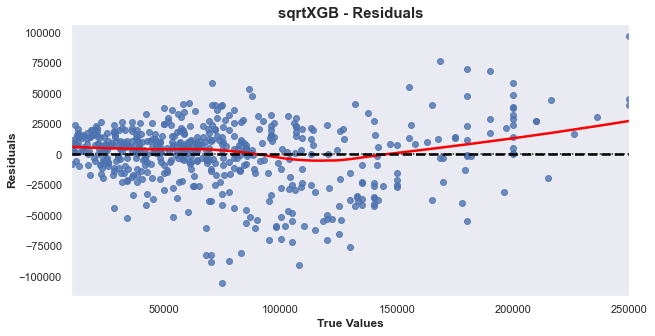

In [42]:
sns.set_theme(style='dark') 

residuales = y_test**2 - y_pred
plt.figure(figsize=(10,5))

sns.residplot(x=y_test**2, y=residuales, lowess=True, line_kws={'color': 'red', 'lw': 2.5}, robust=False)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2.5)

plt.title('sqrtXGB - Residuals', weight='bold', fontsize=15)
plt.xlabel('True Values', weight='bold', labelpad=3.66)
plt.ylabel('Residuals', weight='bold', labelpad=1.66)

plt.show()

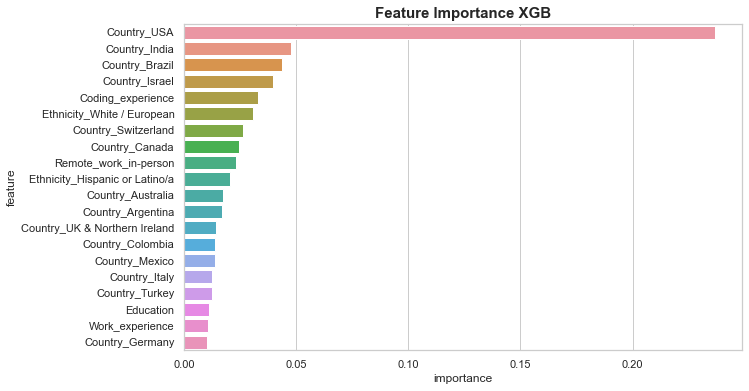

In [39]:
sns.set_theme(style='whitegrid', palette='husl') 
# Accede al modelo usando la clave 'regressor' en lugar de 'model'
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

importances = best_model.named_steps['regressor'].feature_importances_

# Crea un DataFrame con las características y sus importancias
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Ordena por importancia
importance_df = importance_df.sort_values('importance', ascending=False)

# Selecciona solo las n características con los mayores valores de importancia
n = 20
top_importance = importance_df[:n]

# Gráfica las importancias de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_importance)
plt.title('Feature Importance XGB', weight='bold', fontsize=15)
plt.show()


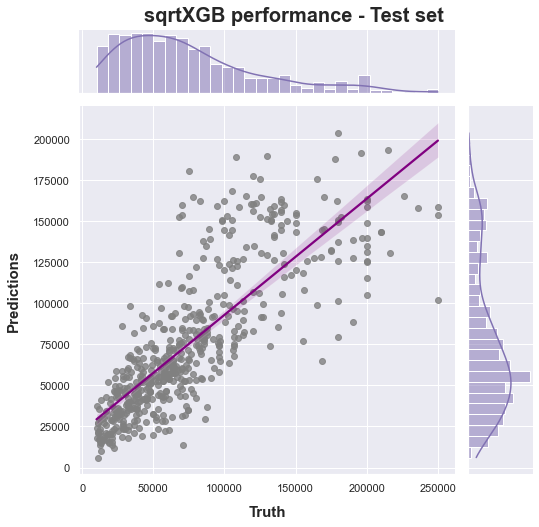

In [38]:
sns.set_theme(style='darkgrid')

# Crear un gráfico conjunto con histogramas marginales
g = sns.jointplot(x=y_test**2, y=y_pred, kind='reg',
                  joint_kws={'color': 'grey', 'line_kws': {'color': 'purple'}},
                  marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

# Ajustar título y etiquetas
g.fig.suptitle("sqrtXGB performance - Test set", weight='bold', y=1.02, fontsize=20)
g.set_axis_labels("Truth", "Predictions", fontsize=15, weight='bold', labelpad=12)

plt.show()
